## Practical Machine Learning : Product Ranking 

   
**Version : 1**

### Table of contents :

- Problem Statement
- High Level Approach
    - Modeling Approach  
    - Data Preprocessing Approach
    - EDA Analysis
    - Modeling Steps
    - Performance Evaluation
- Next steps and future enhancement

### Problem Statement :

Want to show the most relevant products to our users.Assign each product a `score` which you would suggest we should sort by. The product with the biggest score means the most relevant product for our users - so it would end up on top of a page.


### Data:


Product_scoring.csv with 10K unique products , 170 unique categories and 3 columns on clicks,impression and amount.

### Objective:

Share an approch on how we can build a model to predict rank most relevant product for our users

### High Level Approach :


By observing the data we can determine that no convertion data ahs beeen provided, we need to populate either a columns which indicate click vs non_click products. This will help us in prioprising the products for ranking.

Or use Weighted Sum approch to calclate the ranks based on the 3 columns provided.



#### Modeling Approach :

   

- **Level 1:** 
    - We will adopt tree  based techiniques at present to assign rank
    

 

- **Level 2:** 
    
    - We will also WeightedSum just incase to check if we get better output
    
    
    

#### Data Preprocessing  Approach



- Check for missing values and outliers in the data
- Create indicator varible
- Check for data distribution and Skewness



#### EDA Analysis 

- Analysis the Click vs no-click products
- Determine the category with most numbers of product
- Determine the category with most numbers clicks w.r.t product
- Determine the category with most numbers of Impressions
- Determine the category with most numbers of clicks






#### Modeling Steps
   
- Split/Partition the base dataset to build and test your model
- Important varibles
- Predict on test dataset 



#### Performance Evaluation:

- Validate the performance of models on precision & recall value



### Next steps and future enhancement:

- Long term option for model approch and enhancement
- Additional data may help develop more versatile model like recommendation engine


    
    


#### A/B TESTING :

- Evaluate the results from test & control group to check if there are any significant differences post intervention

## <a id='1'>1. Import all the necessary libraries to run our Analysis </a>

In [4]:
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn.metrics as metrics
import itertools
import csv
from scipy import stats
import matplotlib.pyplot as plt
from skcriteria.madm import simple
from sklearn.model_selection  import train_test_split
import sklearn.metrics
from datetime import datetime, timedelta
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
import datetime as dt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve



## <a id='2'>2. Import the dataset to run our Analysis </a>

In [336]:

data = pd.read_csv("product_scoring.csv")

#create a copy of the dataset

data1 = data.copy()

In [337]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   product_id   10000 non-null  float64
 1   category_id  10000 non-null  int64  
 2   cpc          10000 non-null  float64
 3   clicks       10000 non-null  float64
 4   impressions  4439 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB


## <a id='3'>3. Data Preprocessing  </a>

###### Check nulls or missing value

In [338]:
null_counts = data1.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
product_id        0
category_id       0
cpc               0
clicks            0
impressions    5561
dtype: int64


In [339]:
data1['impressions'] = data1['impressions'].fillna(0)

#### Create new column as an indicator of sale

In [340]:
data1['click_indicator'] = data1['clicks'].apply(lambda x: 0 if x == 0 else 1)

/Users/himswamy0/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


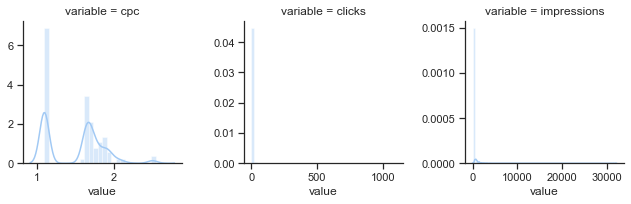

In [334]:
numericCols = data1[['cpc','clicks','impressions']]
f = pd.melt(numericCols)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
#plt.figure(figsize=(20,16))
sns.set(rc={'figure.figsize':(20,15)})

**Observation** :

- All the 3 features have Skewness

## <a id='4'>4. Exploratory Data Analysis</a>

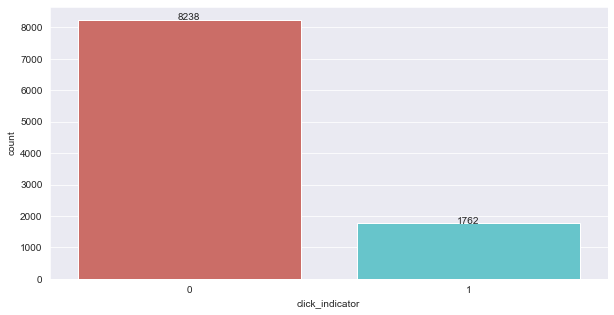

In [22]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='click_indicator',data=data1, palette='hls')

# label each bar in barplot
for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
 y = height+1,
 s = '{:.0f}'.format(height), 
 ha = 'center') 

 **Observation** :
 
- Due to the nature of online business,click through rate (17.6%) is low. So, the class are very imbalanced.

#### Category level Analysis

In [342]:
cat_prod = pd.pivot_table(data1,index=["category_id"],values=["product_id"],aggfunc=[len]).reset_index()
cat_prod.columns = [''] * len(cat_prod.columns)
cat_prod.columns =['category_id', 'product_cnt']
cat_prod1 = cat_prod.sort_values(by = 'product_cnt', ascending = False).head(10)

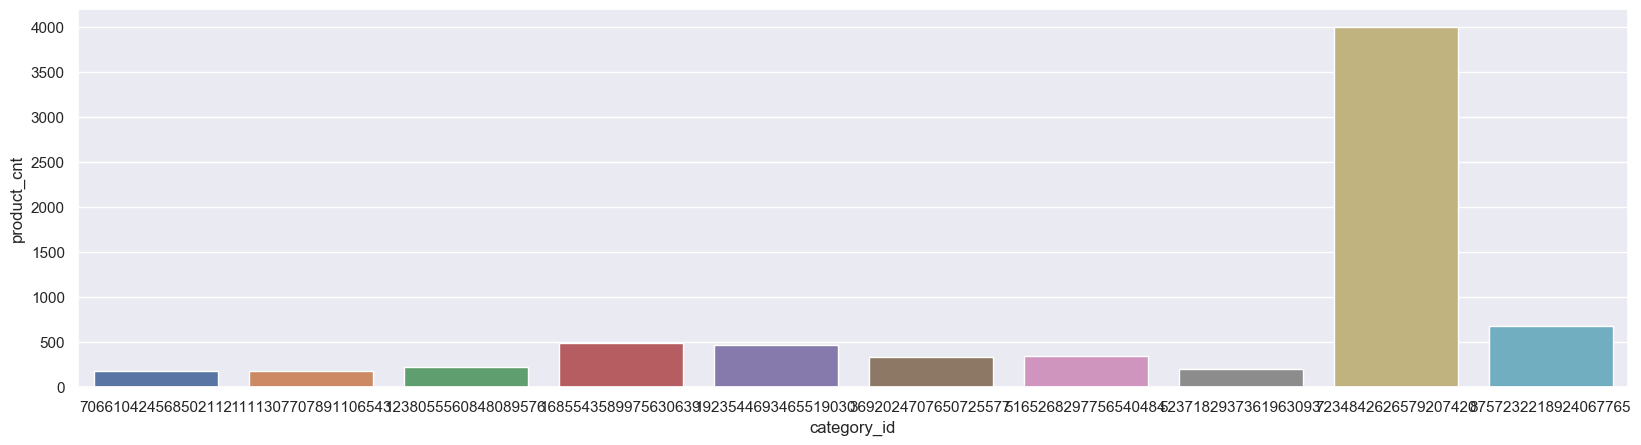

In [343]:
fig, axes = plt.subplots(figsize=(20,5), dpi= 100)
sns.barplot(x = 'category_id',y = 'product_cnt',data = cat_prod1)

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
 y = height+ 20,
 s = '{:.0f}'.format(height), 
 ha = 'center') 

 **Observation** :
 
- Determine the category with most numbers of products, so that in future we can focus on it.

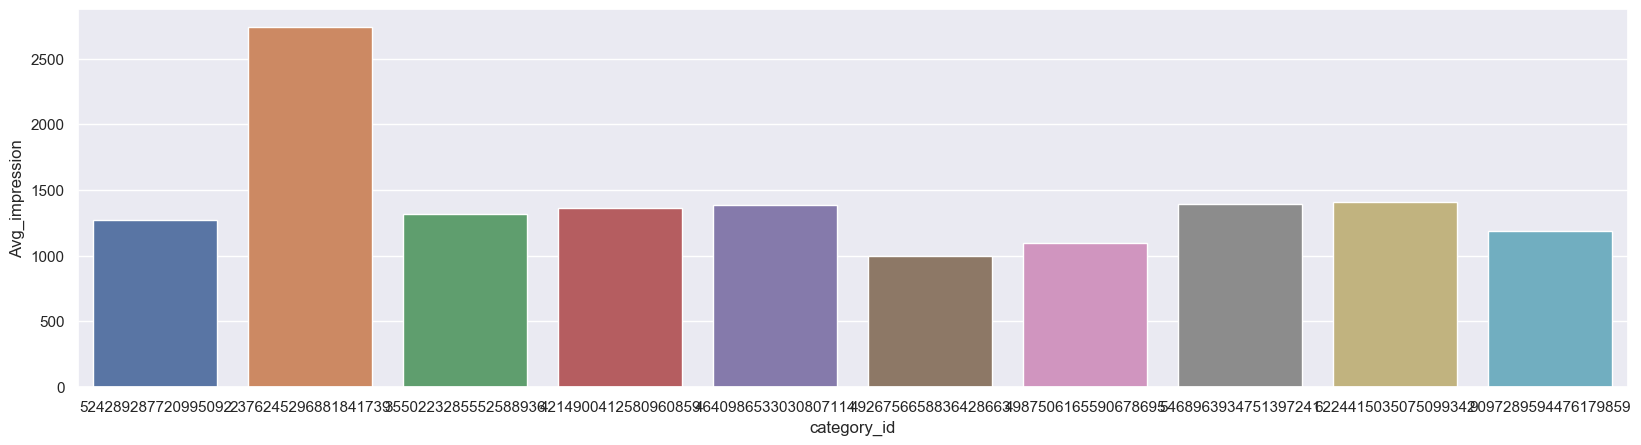

In [341]:
cat_prod = data1.loc[data1['click_indicator'] == 1]
cat_prod = pd.pivot_table(data1,index=["category_id"],values=["impressions"],aggfunc=[np.mean]).reset_index()
cat_prod.columns = [''] * len(cat_prod.columns)
cat_prod.columns =['category_id', 'Avg_impression']
cat_prod1 = cat_prod.sort_values(by = 'Avg_impression', ascending = False).head(10)

fig, axes = plt.subplots(figsize=(20,5), dpi= 100)
sns.barplot(x = 'category_id',y = 'Avg_impression',data = cat_prod1)

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
 y = height+ 10,
 s = '{:.0f}'.format(height), 
 ha = 'center') 

 **Observation** :
 
- Determine the category with most numbers of products w.r.t clicks, so that in future we can focus on it.

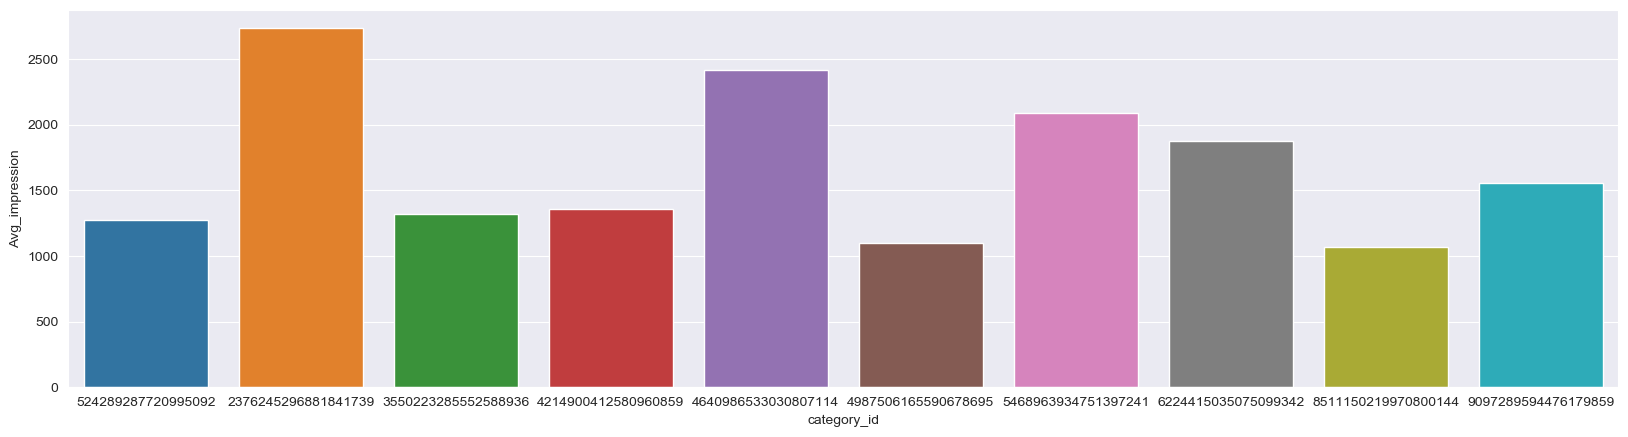

In [92]:

cat_prod = pd.pivot_table(data1,index=["category_id"],values=["impressions"],aggfunc=[np.mean]).reset_index()
cat_prod.columns = [''] * len(cat_prod.columns)
cat_prod.columns =['category_id', 'Avg_impression']
cat_prod1 = cat_prod.sort_values(by = 'Avg_impression', ascending = False).head(10)

fig, axes = plt.subplots(figsize=(20,5), dpi= 100)
sns.barplot(x = 'category_id',y = 'Avg_impression',data = cat_prod1)

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
 y = height+ 10,
 s = '{:.0f}'.format(height), 
 ha = 'center') 

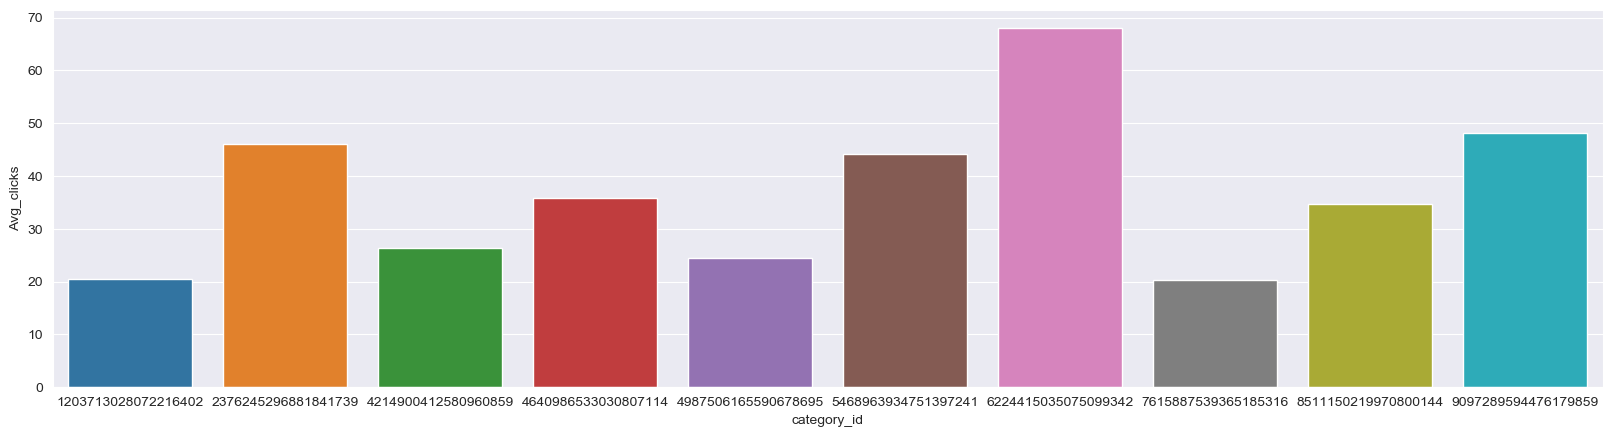

In [93]:
cat_prod = pd.pivot_table(data1,index=["category_id"],values=["clicks"],aggfunc=[np.mean]).reset_index()
cat_prod.columns = [''] * len(cat_prod.columns)
cat_prod.columns =['category_id', 'Avg_clicks']
cat_prod1 = cat_prod.sort_values(by = 'Avg_clicks', ascending = False).head(10)

fig, axes = plt.subplots(figsize=(20,5), dpi= 100)
sns.barplot(x = 'category_id',y = 'Avg_clicks',data = cat_prod1)

for p in ax.patches:
 # get the height of each bar
 height = p.get_height()
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2),
 y = height+ 10,
 s = '{:.0f}'.format(height), 
 ha = 'center') 

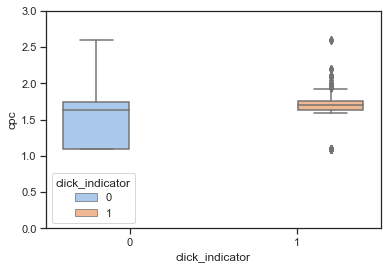

In [97]:
sns.set(style="ticks", palette="pastel")

ax = sns.boxplot(x="click_indicator", y="cpc", hue="click_indicator", data=data1)
ax.set_ylim([0, 3]);

## <a id='5'>5. Implementataion of Machine Learning Models </a>

### Level 1 Predictive Model : Randomforest model for predicting the score for product ranking

In [142]:
y = np.array(data1['click_indicator'])

X = data1.drop(['product_id','category_id','click_indicator'], axis = 1)

feature_list = list(X.columns)


In [171]:
train_x, test_x, train_y, test_y =train_test_split(X,y,test_size=0.3,shuffle=True, 
                                                     stratify=y, random_state= 93456)

In [156]:
model_rfe = RandomForestClassifier(criterion='entropy', random_state=0, 
                                   n_jobs=-1,n_estimators=200,max_depth=11)


rfc_model = model_rfe.fit(train_x, train_y)

rfe=RFE(model_rfe,1)
rfe_fit=rfe.fit(train_x, train_y)
rfe_fit.ranking_
rank=list(rfe_fit.ranking_)
X.columns
col_nm=list(X.columns)
dict_rank={'Column_Name': col_nm,'Ranking':rank}
df_rank=pd.DataFrame(dict_rank)

#### Ranking of Predictor Variables Based on their importance

Text(0.5, 1.0, 'Top Features derived by Random Forest')

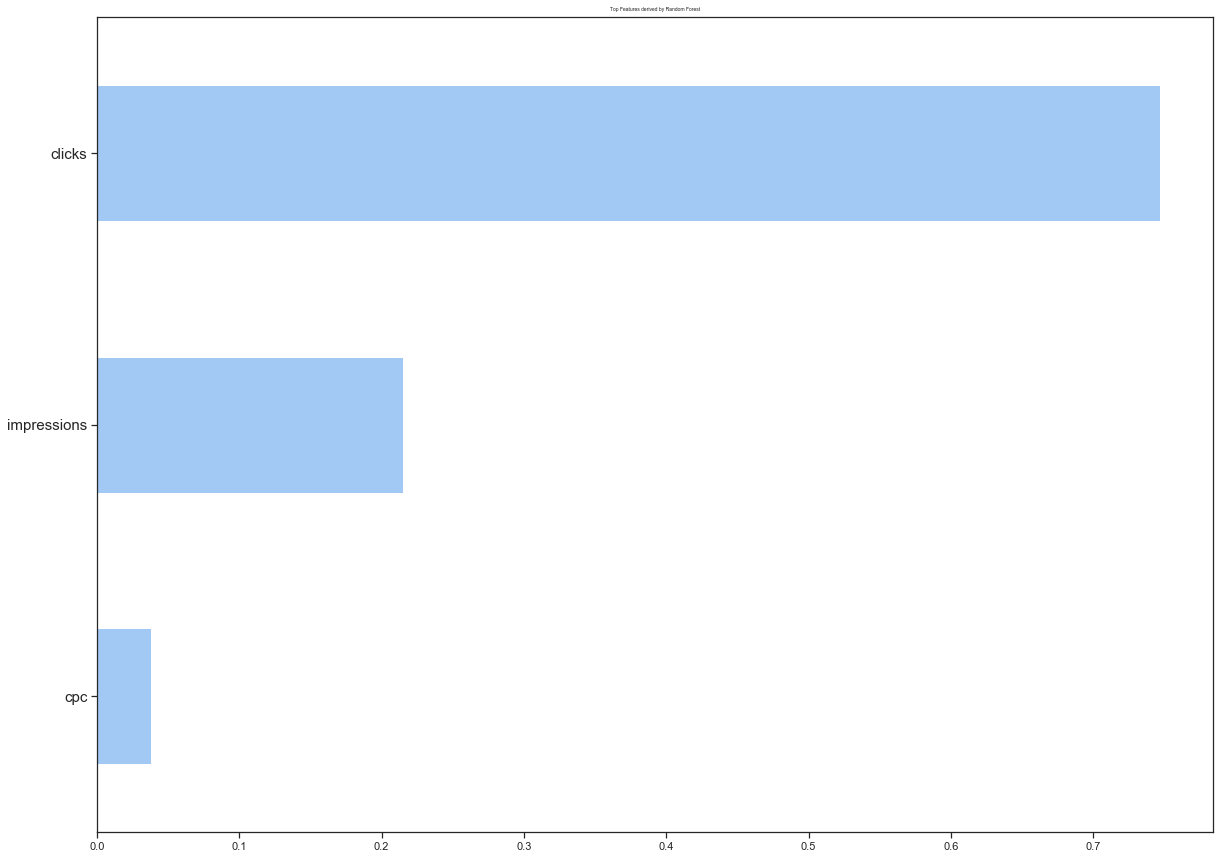

In [157]:
# Plot the top features based on its importance


(pd.Series(rfc_model.feature_importances_, index=X.columns)
   .nlargest(47)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=5)

### Hyperparameter for the best output

In [158]:
rf_param = {'n_estimators':list(range(100,500)) , 
         'max_depth':list(range(1,10)) , 
         'criterion':['gini','entropy'] ,
         'max_samples':list(range(1,10))    
}

In [151]:
from sklearn.model_selection import train_test_split , cross_val_score , RandomizedSearchCV

rf = RandomForestClassifier()

rscv = RandomizedSearchCV(rf ,param_distributions=rf_param ,  
                          cv =5 , n_iter=10 , scoring = 'accuracy',n_jobs =-1 , verbose =10)


rscv.fit(train_x, train_y)


print(rscv.best_score_)
print(rscv.best_estimator_)
print(rscv.best_index_)
print(rscv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    8.6s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    9.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.3s finished


0.9187142857142858
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=9,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=167,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
9
{'n_estimators': 167, 'max_samples': 9, 'max_depth': 3, 'criterion': 'entropy'}


 Test Accuracy (Reduced Data): 100.0000%
Confusion Matrix: 
[[2471    0]
 [   0  529]]
Area Under Curve: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2471
           1       1.00      1.00      1.00       529

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



(<Figure size 720x720 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1c3f4d50>)

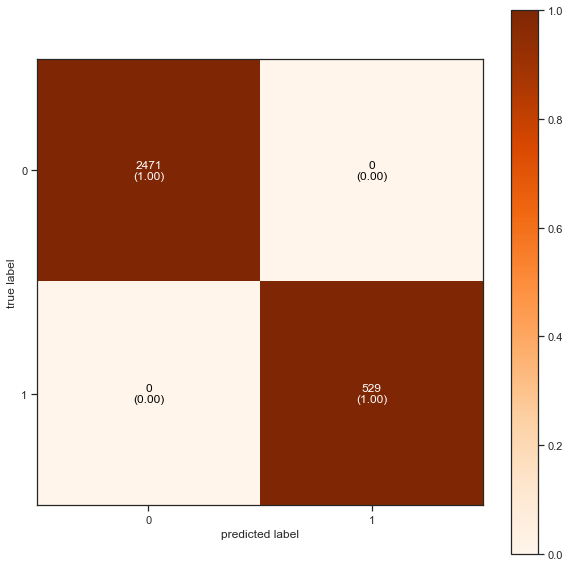

In [162]:
rfc = RandomForestClassifier(criterion='gini',n_estimators=167,max_depth=3,class_weight='balanced')

# Train model
rfc_model = rfc.fit(train_x, train_y)
              
# Predict    
y_pred_rfc = rfc_model.predict(test_x)




print(" Test Accuracy (Reduced Data): {:.4f}%".format(rfc_model.score(test_x, test_y) * 100))
print(f'Confusion Matrix: \n{confusion_matrix(test_y, y_pred_rfc)}')
print(f'Area Under Curve: {roc_auc_score(test_y, y_pred_rfc)}')


print(classification_report(test_y,y_pred_rfc))

plot_confusion_matrix(confusion_matrix(test_y,y_pred_rfc),cmap=plt.cm.Oranges , figsize=(10,10),colorbar=True,
                      show_absolute=True,show_normed=True)

 **Observation** :
 
- This is suppressing the model seems to have determine 1 & 0 perfectly

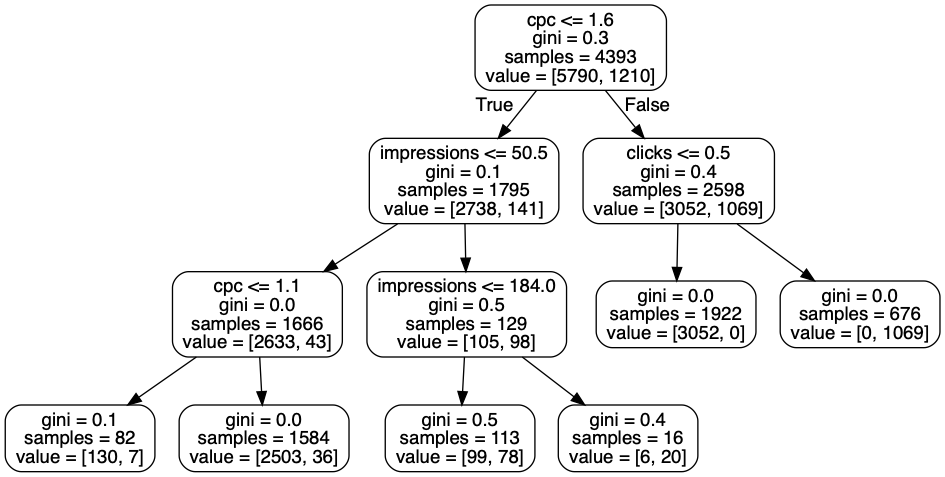

In [163]:
feature_list = list(train_x.columns)

train_important = train_x

train_labels = train_y


# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(train_important, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');


Image(graph.create_png())


 **Observation** :
 
- Explanation of sample output from randomforest

In [202]:
Y_prob_total = rfc_model.predict_proba(test_x)

dtype = [('Col1','int32'), ('Col2','float32')]
values = Y_prob_total
index = ['Row'+str(i) for i in range(1, len(values)+1)]

prob_df1 = pd.DataFrame(values, index=index)
prob_df1.reset_index(inplace=True,drop = True)
pred_log = pd.DataFrame(y_pred_rfc)

pred = pd.concat([pred_log,prob_df1],axis = 1)

pred.columns = ['predicted', 'Prob_low', 'Prob_high']


pred['Actual'] = valid_y

predictions = pred
predictions.index = test_x.index
Test_Pred = test_x.merge(predictions, left_index=True, right_index=True)
Test_base_id = data1[['product_id','category_id']]

Final_test_Pred = Test_base_id.merge(Test_Pred, left_index=True, right_index=True)


Final_test_Pred1 = Final_test_Pred.sort_values(by = 'Prob_high', ascending = False).reset_index(drop=True)

Final_test_Pred1.head(2)

### Final high probability products

In [245]:
Final_test_Pred1['rank'] = Final_test_Pred1.groupby('Prob_high').cumcount() + 1
Final_test_Pred1.head(10)

product_id          category_id       cpc  clicks  impressions  \
0  8.542446e+18  1923544693465519030  1.658668    27.0        667.0   
1  5.381062e+18  5806613474443340534  1.639849     4.0        752.0   
2  4.963768e+18  1923544693465519030  1.657276    11.0        478.0   
3  7.139839e+18  5165268297756540484  1.639203    37.0       1806.0   
4  7.377522e+18  1923544693465519030  1.654306    45.0       1408.0   
5  2.848127e+18  1923544693465519030  1.657239     1.0        451.0   
6  8.941864e+17  7677954191143808172  1.654507    17.0        635.0   
7  8.342249e+18  1923544693465519030  1.656820    10.0        550.0   
8  4.096981e+17  3692024707650725577  1.639758   119.0       3821.0   
9  7.684414e+18  1923544693465519030  1.658535    17.0        526.0   

   predicted  Prob_low  Prob_high  Actual  rank  
0          1  0.028384   0.971616       1     1  
1          1  0.028384   0.971616       1     2  
2          1  0.028384   0.971616       1     3  
3          1  0.028384   0.971616       1     4  
4          1  0.028384   0.971616       1     5  
5          1  0.028384   0.971616       1     6  
6          1  0.028384   0.971616       1     7  
7          1  0.028384   0.971616       1     8  
8          1  0.028384   0.971616       1     9  
9          1  0.028384   0.971616       1    10

---------------------------


## <a id='Level 2'>Level 2. Algorithms: WeightedSum </a>

In [256]:
data2 = data1.loc[:, ['product_id', 'cpc', 'clicks', 'impressions']]
data2

product_id       cpc  clicks  impressions
0     6.288768e+18  1.100000     0.0         26.0
1     7.511866e+18  1.800000     0.0        156.0
2     1.249888e+17  1.640000     2.0         44.0
3     1.943562e+18  1.100000     0.0          0.0
4     4.896302e+18  1.099999     0.0          0.0
...            ...       ...     ...          ...
9995  3.851190e+18  1.694257     0.0          0.0
9996  4.190404e+18  1.794257     0.0         27.0
9997  7.119700e+18  1.694257    13.0        501.0
9998  8.766075e+18  1.094257     0.0          0.0
9999  7.636591e+18  2.194256     0.0          0.0

[10000 rows x 4 columns]

In [259]:
from skcriteria import Data, MIN, MAX

criteria_data = Data(
    data2.iloc[:, 1:],          # the pandas dataframe
    [MAX, MAX, MAX],      # direction of goodness for each column
    anames = data2['product_id'], # each entity's name, here car name
    cnames = data2.columns[1:], # attribute/column name
    )
criteria_data

ALT./CRIT.    cpc (max)    clicks (max)    impressions (max)
------------  -----------  --------------  -------------------
6.28877e+18       1.1            0                 26
7.51187e+18       1.8            0                 156
1.24989e+17      1.64            2                 44
1.94356e+18       1.1            0                  0
 4.8963e+18       1.1            0                  0
1.06776e+18      1.64            5                 120
5.05478e+18       1.1            0                  0
9.08179e+18       1.7            0                  0
6.72061e+18      1.66            0                 21
8.66197e+18      1.66            0                 59
8.19405e+18     1.69999          0                 24
1.03566e+17     1.09999          0                  0
4.22336e+18     1.63999          0                 59
1.05209e+18     1.09999          0                  0
2.99606e+18     1.89999          2                 176
5.33919e+18     1.63999          0                 48
2.95768e+18     1.09999          0                  0
3.98557e+18     1.89999         999               17510
 8.5016e+18     1.09999          0                  0
2.23397e+17     1.79999          0                 34
7.42404e+17     1.79998          0                 144
2.35907e+18     1.09998          0                  0
1.85989e+18     1.63998          0                 135
 5.514e+18      1.69998          36               1736
6.19971e+18     1.09998          0                  0
5.29663e+18     1.65998          3                 87
1.91869e+18     1.09998          0                  0
7.21359e+18     1.63998          0                  0
5.39931e+18     1.63998          0                 37
1.83639e+18     1.69998          0                 25
4.09883e+17     1.65998          0                 91
2.84392e+18     1.69998          53               2771
 5.2974e+18     1.63998          8                 731
1.65916e+18     1.63998          0                  0
7.01567e+18     2.49998          0                  0
8.71222e+18     1.09997          0                  0
1.00638e+18     1.69997          0                  0
6.99355e+18     1.95997          0                  0
6.50225e+18     1.89997          0                 72
8.66722e+18     1.89997          0                  0
1.35868e+18     1.09997          0                  0
 4.3208e+18     1.09997          0                  0
 5.0934e+18     1.63997          0                  0
4.78489e+18     1.09997          0                  0
3.49473e+18     1.63997          15               1259
3.70212e+18     1.59997          0                 76
2.63119e+18     1.89997          0                 91
3.69469e+18     1.63997          0                 59
5.58741e+18     1.63997          0                 52
2.23384e+18     1.89997          0                  0
8.87874e+18     1.63997          0                 100
4.73378e+18     1.69997          16                981
5.93184e+18     1.09997          0                  0
2.28579e+18     1.09996          0                  0
2.57267e+16     1.89996          15               1014
6.10839e+18     1.63996          0                 49
1.66345e+18     1.09996          0                  0
4.09419e+18     1.63996          0                 28
6.64187e+18     1.73996          0                 219
4.23745e+18     2.03996          0                  0
7.89728e+18     1.73996          0                 79
3.99112e+18     1.09996          0                  0
5.24621e+18     1.65996          0                  0
4.44816e+18     1.63996          0                 429
5.13392e+18     1.69996          0                 92
2.62441e+17     1.09996          0                  0
3.42166e+18     1.79996          0                 29
4.51557e+18     1.09996          0                  0
3.16414e+18     1.69996          32               1936
7.78269e+18     1.09996          0                  0
6.55827e+17     1.69995          9                 291
5.21116e+18     1.79995 

In [292]:

# Functions
def normalize_data(logic="minmax"):
    df = data2.iloc[:, 1:].values.copy()
    if logic == "minmax":
        normalized_data = minmax_scale(df)
        normalized_data[:, 1] = 1 - normalized_data[:, 1]
        normalized_data[:, 2] = 1 - normalized_data[:, 2]
    elif logic == "sumNorm":
        normalized_data = df / df.sum(axis=0)
        normalized_data[:, 1] = 1 / normalized_data[:, 1]
        normalized_data[:, 2] = 1 / normalized_data[:, 2]
    elif logic == "maxNorm":
        normalized_data = df / df.max(axis=0)
        normalized_data[:, 1] = 1 / normalized_data[:, 1]
        normalized_data[:, 2] = 1 / normalized_data[:, 2]
        return normalized_data
    
def plot_heatmap(logic="minmax"):
    plot_data = normalize_data(logic)
    data2_names = data2['product_id']
    attribute_names = data2.columns[1:]
    sns.heatmap(plot_data, annot=True, yticklabels = data2_names, xticklabels = attribute_names, fmt='.3g')
  #
#plot_heatmap("sumNorm")
# normalize_data("maxNorm")

normalize_data("maxNorm")

/Users/himswamy0/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/himswamy0/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


array([[4.23112011e-01,            inf, 1.23723077e+03],
       [6.92365080e-01,            inf, 2.06205128e+02],
       [6.30821428e-01, 5.47500000e+02, 7.31090909e+02],
       ...,
       [6.51691413e-01, 8.42307692e+01, 6.42075848e+01],
       [4.20902860e-01,            inf,            inf],
       [8.44014820e-01,            inf,            inf]])

In [294]:

from skcriteria.madm import simple
# weighted sum
dm = simple.WeightedSum(mnorm="sum")
dec = dm.decide(criteria_data)
dec

WeightedSum (mnorm=sum, wnorm=sum) - Solution:
 ALT./CRIT.    cpc (max)    clicks (max)    impressions (max)    Rank
------------  -----------  --------------  -------------------  ------
6.28877e+18       1.1            0                 26            6575
7.51187e+18       1.8            0                 156           1845
1.24989e+17      1.64            2                 44            2001
1.94356e+18       1.1            0                  0            6757
 4.8963e+18       1.1            0                  0            6758
1.06776e+18      1.64            5                 120           1067
5.05478e+18       1.1            0                  0            6759
9.08179e+18       1.7            0                  0            5441
6.72061e+18      1.66            0                 21            4637
8.66197e+18      1.66            0                 59            3062
8.19405e+18     1.69999          0                 24            4155
1.03566e+17     1.09999          0                  0            6760
4.22336e+18     1.63999          0                 59            3097
1.05209e+18     1.09999          0                  0            6761
2.99606e+18     1.89999          2                 176           1268
5.33919e+18     1.63999          0                 48            3363
2.95768e+18     1.09999          0                  0            6762
3.98557e+18     1.89999         999               17510           2
 8.5016e+18     1.09999          0                  0            6763
2.23397e+17     1.79999          0                 34            3408
7.42404e+17     1.79998          0                 144           1902
2.35907e+18     1.09998          0                  0            6764
1.85989e+18     1.63998          0                 135           2045
 5.514e+18      1.69998          36               1736           103
6.19971e+18     1.09998          0                  0            6765
5.29663e+18     1.65998          3                 87            1489
1.91869e+18     1.09998          0                  0            6766
7.21359e+18     1.63998          0                  0            5911
5.39931e+18     1.63998          0                 37            3667
1.83639e+18     1.69998          0                 25            4129
4.09883e+17     1.65998          0                 91            2407
2.84392e+18     1.69998          53               2771            63
 5.2974e+18     1.63998          8                 731           364
1.65916e+18     1.63998          0                  0            5912
7.01567e+18     2.49998          0                  0            2738
8.71222e+18     1.09997          0                  0            6767
1.00638e+18     1.69997          0                  0            5442
6.99355e+18     1.95997          0                  0            4296
6.50225e+18     1.89997          0                 72            2412
8.66722e+18     1.89997          0                  0            4681
1.35868e+18     1.09997          0                  0            6768
 4.3208e+18     1.09997          0                  0            6769
 5.0934e+18     1.63997          0                  0            5913
4.78489e+18     1.09997          0                  0            6770
3.49473e+18     1.63997          15               1259           195
3.70212e+18     1.59997          0                 76            2642
2.63119e+18     1.89997          0                 91            2224
3.69469e+18     1.63997          0                 59            3098
5.58741e+18     1.63997          0                 52            3249
2.23384e+18     1.89997          0                  0            4682
8.87874e+18     1.63997          0                 100           2326
4.73378e+18     1.69997          16                981           223
5.93184e+18     1.09997          0                  0            6771
2.28579e+18     1.09996          0                  0            6772
2.57267e+16     1.89996          15    

In [345]:

Final_dataset = data2.copy()

# weighted sum, sumNorm
dm = simple.WeightedSum(mnorm="sum")
dec = dm.decide(criteria_data)
Final_dataset.loc[:, 'rank_weightedSum_sumNorm_inverse'] = dec.rank_

# sort for better visualization
Final_dataset.sort_values(by=['rank_weightedSum_sumNorm_inverse'], inplace=True)

#### Final Dataset with the Ranking of products

In [346]:
Final_dataset

product_id       cpc  clicks  impressions  \
2991  6.837430e+17  1.638306  1095.0      32168.0   
17    3.985574e+18  1.899988   999.0      17510.0   
6572  5.529136e+18  1.896176   808.0      19418.0   
5386  4.294393e+17  1.696891   722.0      12280.0   
8304  3.697538e+18  1.755191   469.0      18406.0   
...            ...       ...     ...          ...   
9988  3.500105e+18  1.094260     0.0          0.0   
9990  5.827685e+18  1.094259     0.0          0.0   
9991  7.157913e+18  1.094259     0.0          0.0   
9993  4.270224e+18  1.094258     0.0          0.0   
9998  8.766075e+18  1.094257     0.0          0.0   

      rank_weightedSum_sumNorm_inverse  
2991                                 1  
17                                   2  
6572                                 3  
5386                                 4  
8304                                 5  
...                                ...  
9988                              9996  
9990                              9997  
9991                              9998  
9993                              9999  
9998                             10000  

[10000 rows x 5 columns]

In [348]:
plot_heatmap("maxNorm")

In [ ]:
plot_heatmap("minmax")

-----------------------------

### Next steps and future enhancement

As a next steps below are some of the suggections:-
    

- Since i have use Tree based model this approch can be reused for any product level.we need to enhance the data. 
    

- In the current approch we need more data like add to cart,Bought,User Behavior Data,User Demographic Data,Product Attribute, ,Previous purchase history of product, what discuount was offered,digital interaction of the products,how many times they clicked on it and spend time on that particular webpage
    
    
- Alternative approch We can build a recommendation systems

- Once we close on the model, we can build a look alike model to target the new products as well, with ceratin featutes.

----------------------------------------------------------

## A/B test analysis

In [304]:

data_a = pd.read_csv("clicks_per_session_a.csv")
data_b = pd.read_csv("clicks_per_session_b.csv")


#### Check the mean for 2 datasets

In [329]:
print(data_a.clicks.mean())

print(data_b.clicks.mean())

1.0368189419945428
1.0360746231863642


#### Check the distribution for 2 datasets

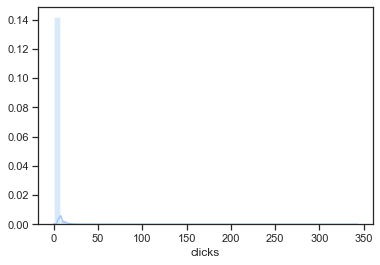

In [305]:
sns.distplot(data_a.clicks)

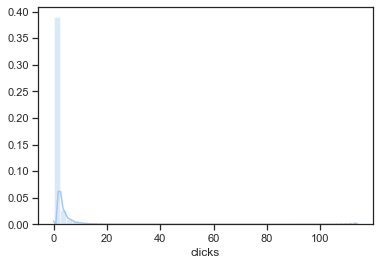

In [306]:
sns.distplot(data_b.clicks)

#### Check the outlier for 2 datasets

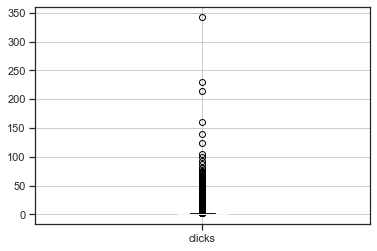

In [307]:
boxplot = data_a.boxplot(column=['clicks'])

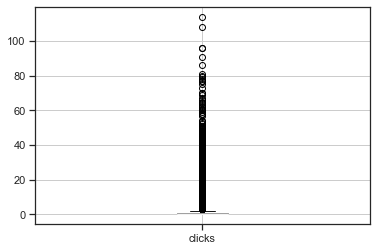

In [308]:
boxplot = data_b.boxplot(column=['clicks'])

#### Check the underline distribution for 2 datasets since its not normal

Text(0.5, 1.0, 'clicks_a_Q-Q Plot')

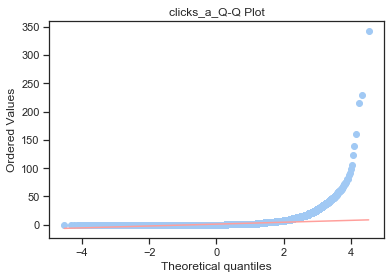

In [311]:

stats.probplot(data_a['clicks'], dist="norm", plot=plt)
plt.title("clicks_a_Q-Q Plot")

Text(0.5, 1.0, 'clicks_a_Q-Q Plot')

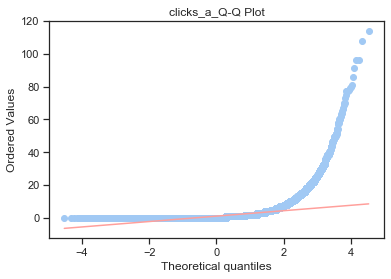

In [312]:
stats.probplot(data_b['clicks'], dist="norm", plot=plt)
plt.title("clicks_a_Q-Q Plot")

In [331]:
print(stats.shapiro(data_a['clicks']))
print(stats.shapiro(data_b['clicks']))

(0.35040098428726196, 0.0)
(0.40271300077438354, 0.0)


/Users/himswamy0/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


 **Observation** :
 
- Both of the variables have a significant p-value which means each variable violates the assumption of normality.   Therefore, the Mann–Whitney–Wilcoxon (MWW), is the correct test to use to analyze this data.

### Since the data doesn't showcase a normal distribution we need to use Nonparametric Statistical Significance Tests

### Wilcoxon–Mann–Whitney test

In [327]:
from scipy.stats import mannwhitneyu
mannwhitneyu(data_a['clicks'], data_b['clicks'])


MannwhitneyuResult(statistic=25793664056.5, pvalue=0.34998941009146545)

We fail to reject the null hypothesis and there is no significant difference can be assumed